<div style="text-align:center; background-color:#cc6600; color:white; padding:15px; border-radius:10px; font-size:26px; font-weight:bold; font-family:'Courier New', monospace;">
  DIGIT RECOGNIZER
</div>

<div style="color:#4B4B4B; padding:5px; font-size:25px; font-weight:bold; font-family:'Courier New', monospace;">
  Importing Required Libraries
</div>

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import layers, models
from itertools import product
import random

2025-07-18 12:50:36.877544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752843037.112012      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752843037.183090      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style="color:#4B4B4B; padding:5px; font-size:25px; font-weight:bold; font-family:'Courier New', monospace;">
  Load the dataset
</div>

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
num_samples = train_data.shape[0]
print(f'Number of samples: {num_samples}')

Number of samples: 42000


<div style="color:#4B4B4B; padding:5px; font-size:25px; font-weight:bold; font-family:'Courier New', monospace;">
  Explore the Dataset (EDA)
</div>

<div style="color:#696969; padding:5px; font-size:18px; font-weight:bold; font-family:'Courier New', monospace;">
  <span style="color: #cc6600;">Missing Data Check</span><br><br>
    In this case - digit recognizer, it is very important to check if any values are missing. Our data are pixels so we cannot do imputation, because the exact position and value of each pixel matters for image, and filling missing pixels would distort the image information. The only option would be to delete samples with missing data, if any exist.
</div>

In [5]:
# Show columns with missing values
missing_data = train_data.isnull().sum().sum() # First .sum() -> sums missing values per column, Second .sum() -> sums across all columns
if missing_data > 0:
    print(f'Dataset contains missing values')
else:
    print(f'No columns have missing values')

No columns have missing values


<div style="color:#cc6600; padding:5px; font-size:18px; font-weight:bold; font-family:'Courier New', monospace;">
  From 784 Numbers to an Image 🤯
</div>

In [6]:
# Check image shape
from typing import Optional

def check_img_shape(dataset) -> Optional[int]:

    num_pixels = train_data.shape[1] - 1 # number of columns minus 1 (label)
    size = int(np.sqrt(num_pixels))
    if size * size == num_pixels:
        print(f'Image is square-shaped: {size}x{size}')
        return size
    else:
        print('Image is not square-shaped')
        return None

In [7]:
image_size = check_img_shape(train_data)

Image is square-shaped: 28x28


In [8]:
# Image save and show

def show_img(dataset, number_index: int) -> None:
    
    pixels = dataset.iloc[number_index, 1:].values.reshape(image_size, image_size)
    # .values -> bierze same wartości z Series i zapisuje do tablicy numpy 1D; alternatywnie: to_numpy()
    # .reshape() -> przekształca 1D tablicę (784) do 2D obrazu (28x28)
    label = dataset.iloc[number_index, 0]
    
    plt.imshow(pixels, cmap='gray')
    plt.title(f'label = {label}')
    plt.axis('off')
    plt.show()

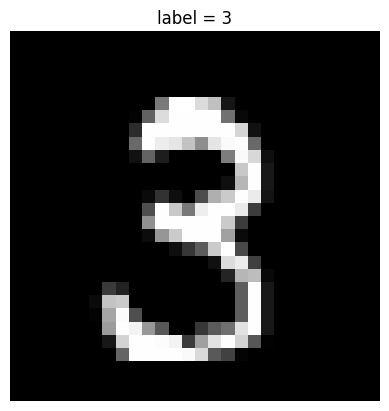

In [9]:
show_img(train_data, 36)

<div style="color:#696969; padding:5px; font-size:18px; font-weight:bold; font-family:'Courier New', monospace;">
  <span style="color: #cc6600;">Balance Check 🧮</span><br><br>
  The dataset contains many classes (10), so it is important to check for imbalance.  
  As the number of classes increases, the risk of having imbalanced data also increases, because some classes might have very few samples compared to others.
</div>

In [10]:
label_counts = train_data['label'].value_counts().sort_index()
print(label_counts)

print(f'Majority class: {label_counts.idxmax()}: {label_counts.max()}')
print(f'Minority class: {label_counts.idxmin()}: {label_counts.min()}')

label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: count, dtype: int64
Majority class: 1: 4684
Minority class: 5: 3795


Median count: 4157.0


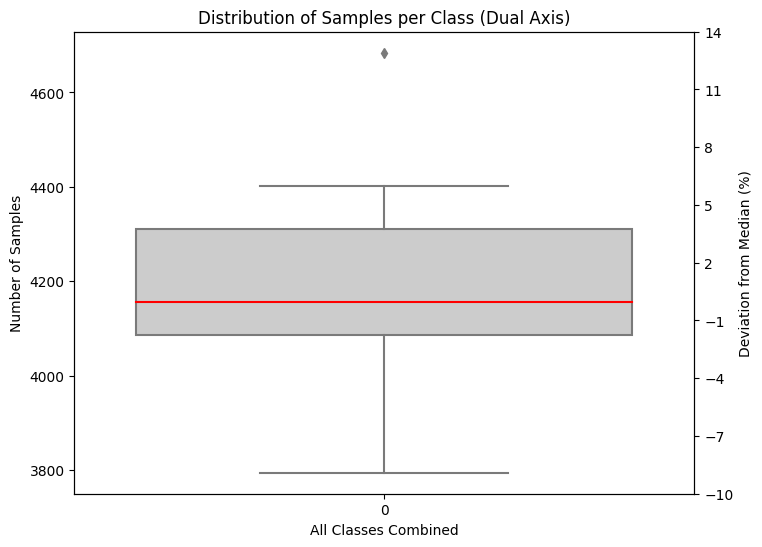

In [11]:
# Distribution of Number of Samples (Boxplot) with percentage deviation

median_count = label_counts.median()
print(f'Median count: {median_count}')
percent_deviation = ((label_counts - median_count) / median_count) * 100

fig, ax1 = plt.subplots(figsize = (8,6))

sns.boxplot(data=label_counts, color='.8', medianprops={"color": "r"}, ax=ax1)
ax1.set_ylabel('Number of Samples')

ax2 = ax1.twinx()
ax2.set_ylim(
    ((min(label_counts) - median_count) / median_count) * 100,
    ((max(label_counts) - median_count) / median_count) * 100
)
ax2.set_ylabel('Deviation from Median (%)')
ax2.set_yticks(np.arange(-10, 15, 3))

plt.title('Distribution of Samples per Class (Dual Axis)')
ax1.set_xlabel('All Classes Combined')

plt.show()

<div style="background-color: #f9f9f9; border-left: 6px solid #696969; padding: 15px; font-family: 'Courier New', sans-serif; font-size: 16px; line-height: 1.6;">
  <strong>Class Distribution Analysis</strong><br><br>

  Most classes have between <strong>3800</strong> and <strong>4400</strong> samples 
  (with a <strong>median of 4157 samples</strong>).<br><br>
  As we can see in the boxplot above, there's only one outlier, which suggests that our dataset is 
  <strong>slightly imbalanced</strong> — due to the class labeled <code>'1'</code>.<br><br>
  This class has about <strong>13% more samples than the median</strong>, which is not a significant imbalance, 
  so most machine learning models should be able to handle it without major issues.<br><br>
  However, I will observe the model’s predictions using a <strong>confusion matrix</strong> to check if it 
  tends to overfit on class '1' or underfit on class '5', which has the lowest sample count.
</div>


<div style="color:#696969; padding:5px; font-size:18px; font-weight:bold; font-family:'Courier New', monospace;">
  <span style="color: #cc6600;">Pixel Value Range Check [0 - 255]</span><br><br>
    I wanna check if all pixels are between 0 and 255. Any deviations suggest errors, so we would delete those samles.
</div>

In [12]:
pixel_data = train_data.iloc[:,1:]

min_pixel = pixel_data.min().min()
max_pixel = pixel_data.max().max()
if min_pixel < 0 or max_pixel > 255:
    print('Warning: Some pixel values are out of the range [0, 255]')
else:
    print('All pixel values are within the expected range [0, 255]')

All pixel values are within the expected range [0, 255]


<div style="color:#696969; padding:5px; font-size:18px; font-weight:bold; font-family:'Courier New', monospace;">
  <span style="color: #cc6600;">Pixel Intensity Distribution Check</span><br><br>
    Pixel that are too light may not be recognized well by the model, so this is important to check if pixel values need enhancement.
</div>

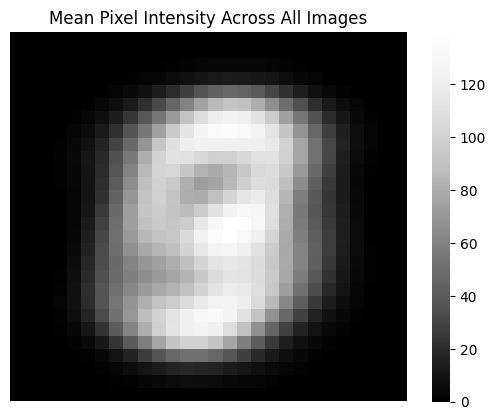

In [13]:
pixels_only = train_data.iloc[:, 1:].values
mean_pixels = pixels_only.mean(axis=0).reshape(image_size, image_size)

sns.heatmap(
    data=mean_pixels,
    cmap='Greys_r',
    cbar=True
)
plt.title('Mean Pixel Intensity Across All Images')
plt.axis('off')
plt.show()

<div style="background-color: #f9f9f9; border-left: 6px solid #696969; padding: 15px; font-family: 'Courier New', sans-serif; font-size: 16px; line-height: 1.6;">
  <strong>Mean Pixel Intensity Analysis</strong><br><br>
Heatmap shows that <strong>contrast between background and the digit is clear</strong>, so there is no need to enhance it.  
To overall shape in the heatmap looks like a blend of different digits, which is expected and indicates that the digits are well-centered and distinct.
</div>

<div style="color:#696969; padding:5px; font-size:18px; font-weight:bold; font-family:'Courier New', monospace;">
  <span style="color: #cc6600;">Digit Gallery</span><br><br>
      To visually inspect the dataset I displayed a few examples from each digit class (0-9).
    This helps to verify the digits are clear and check whether any class contains anomalies. 
</div>

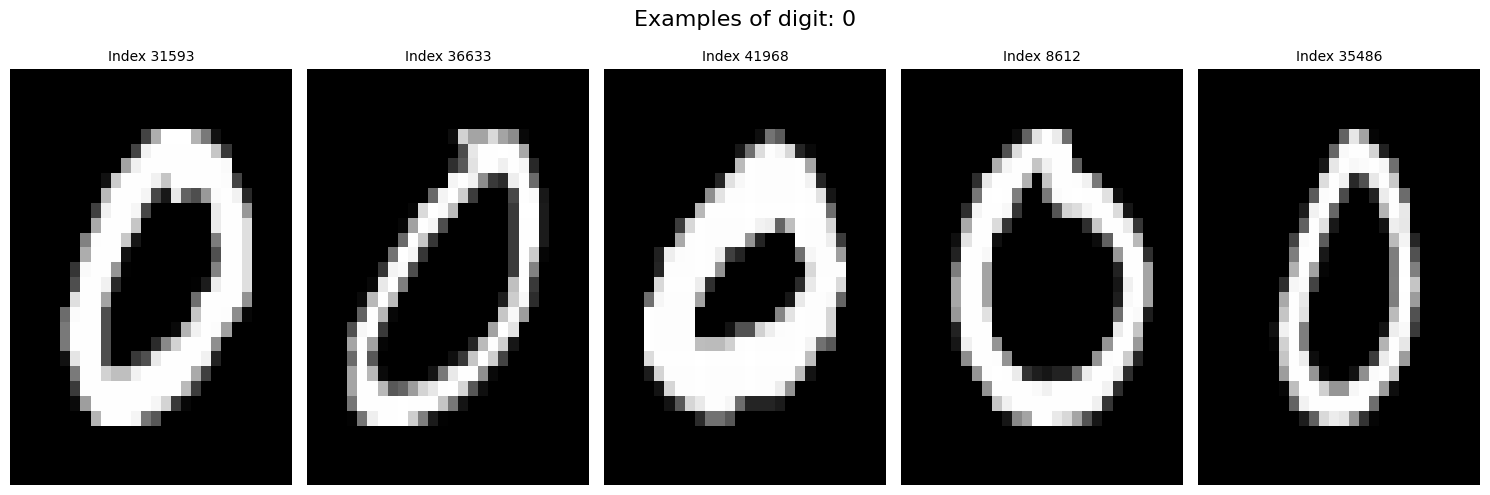

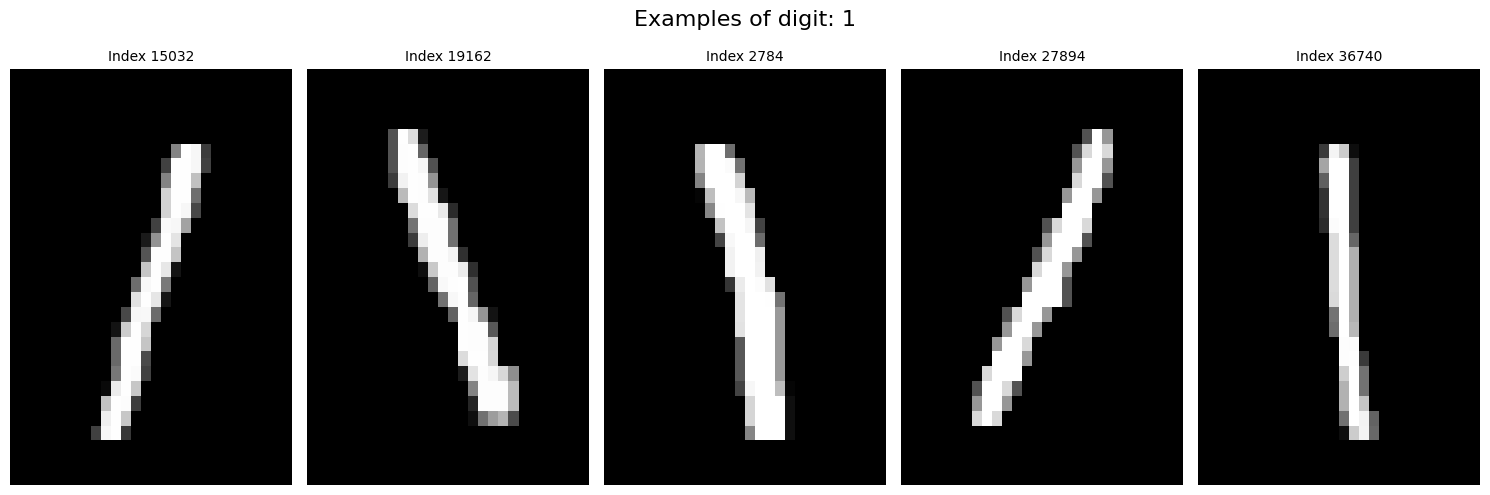

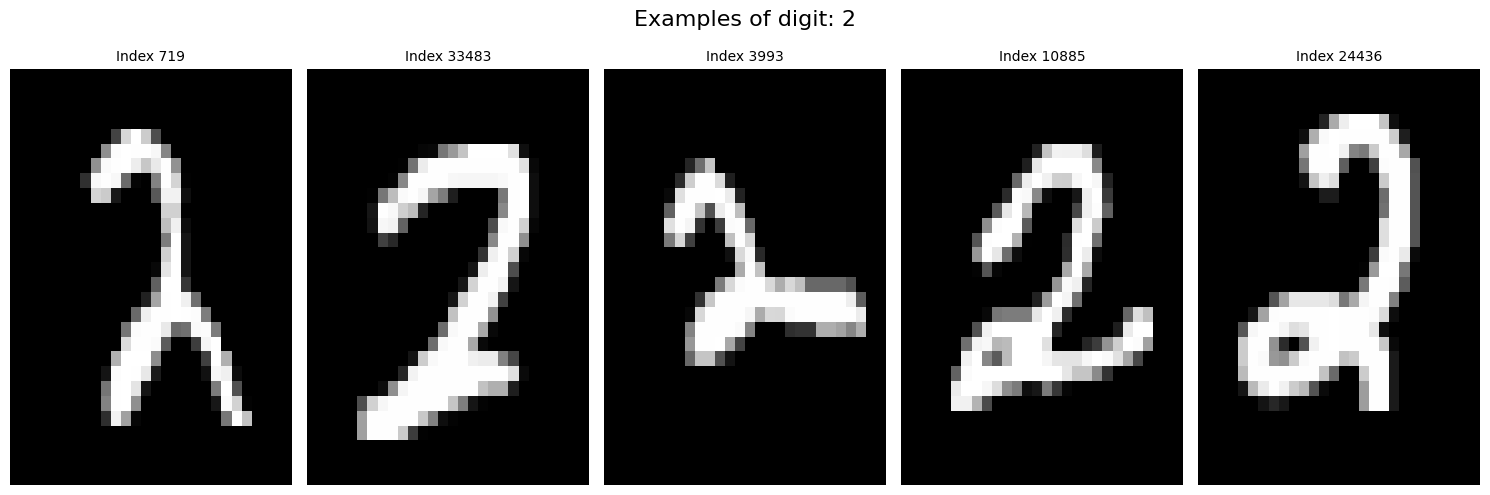

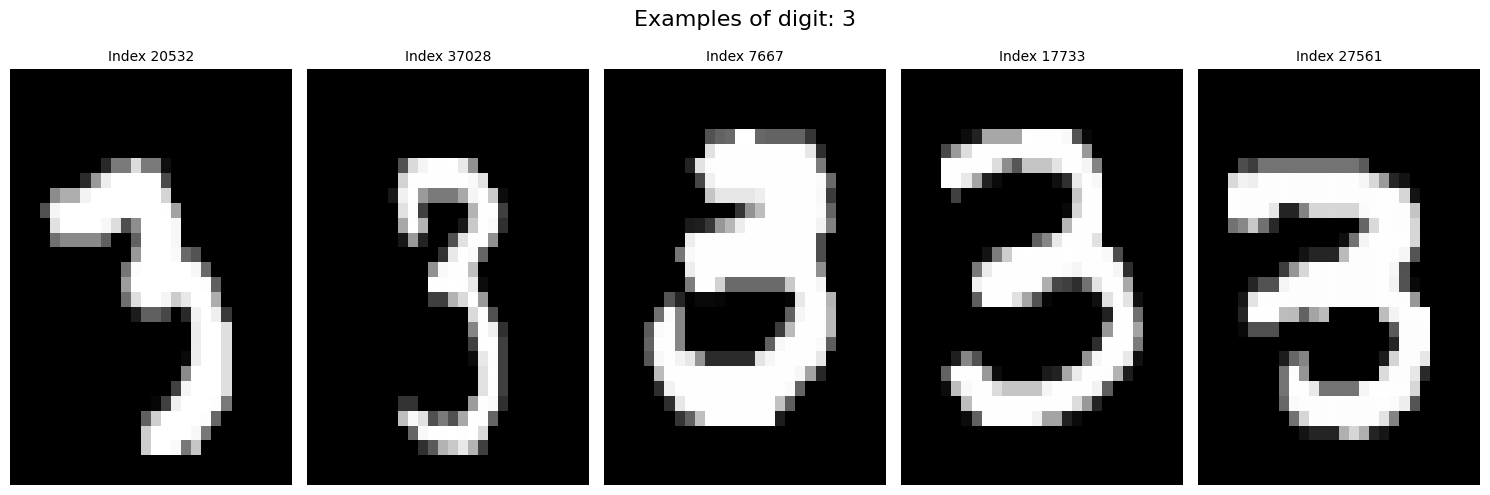

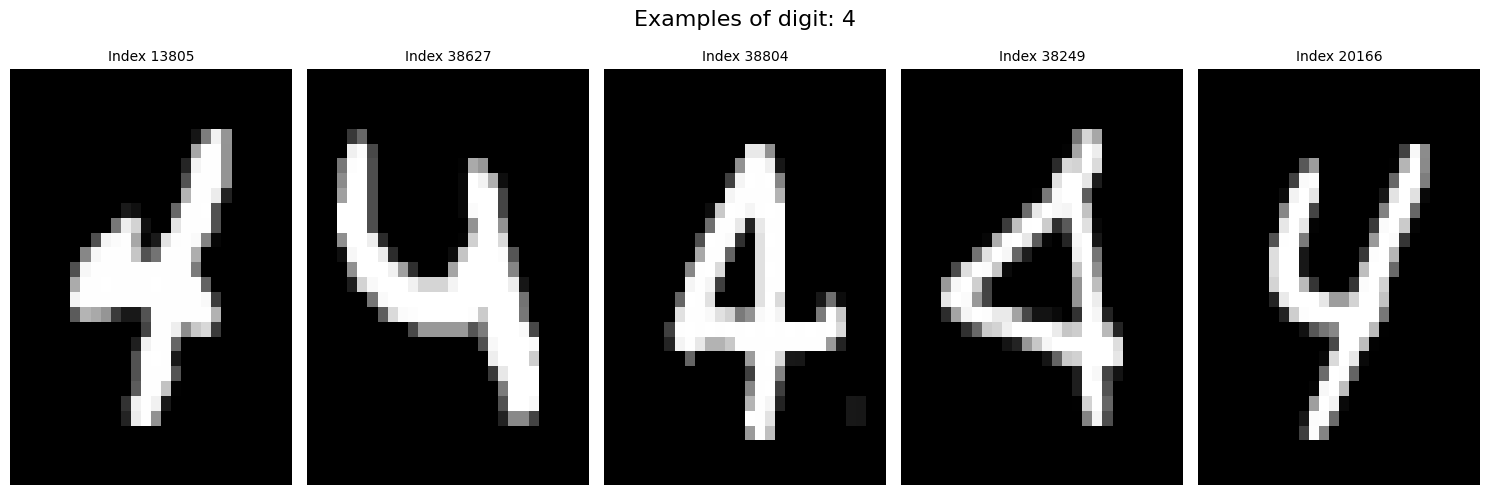

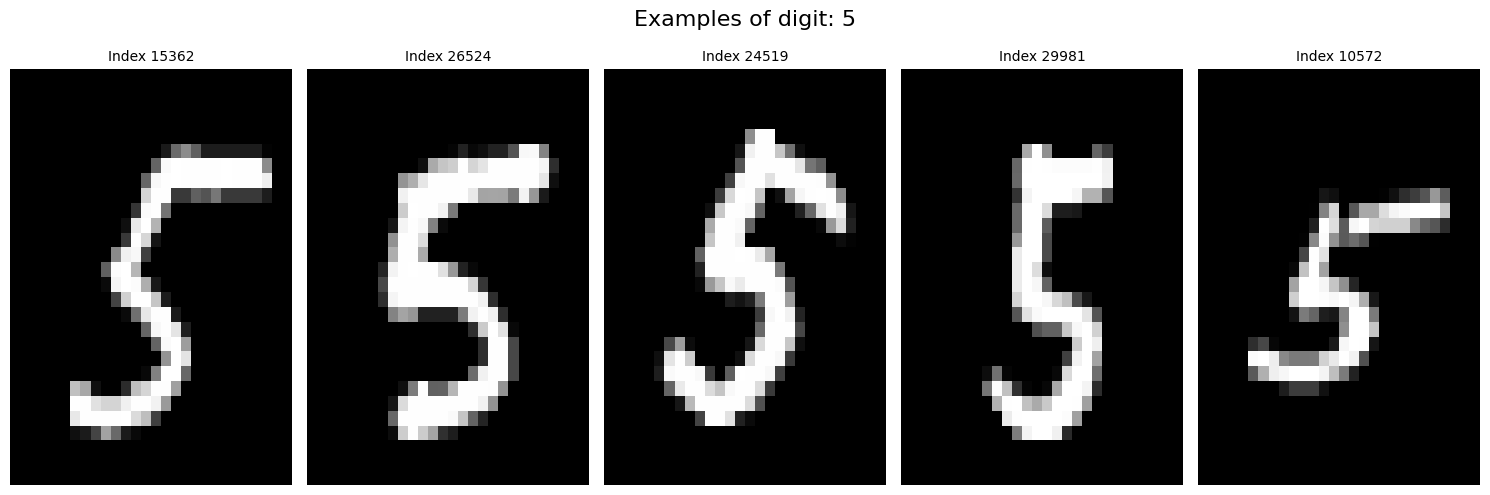

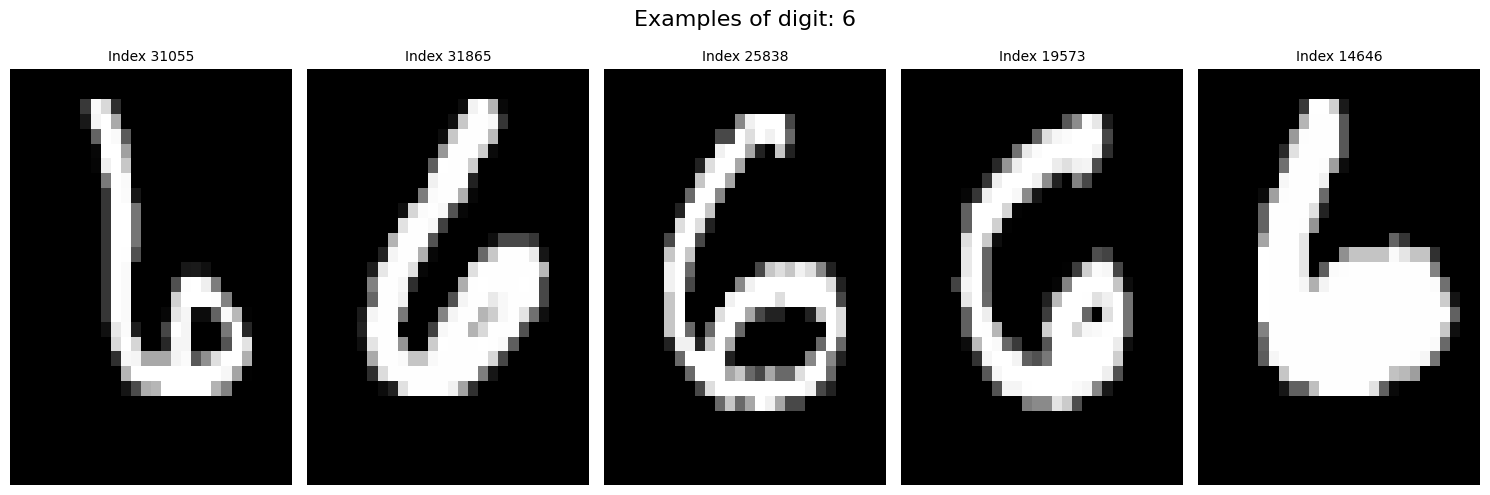

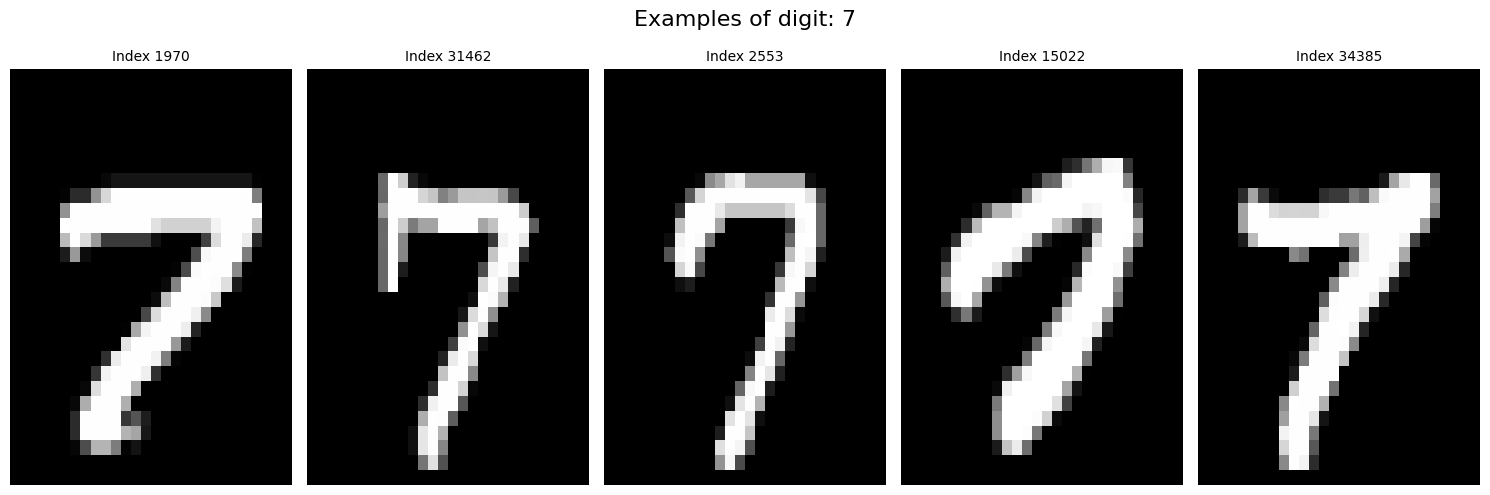

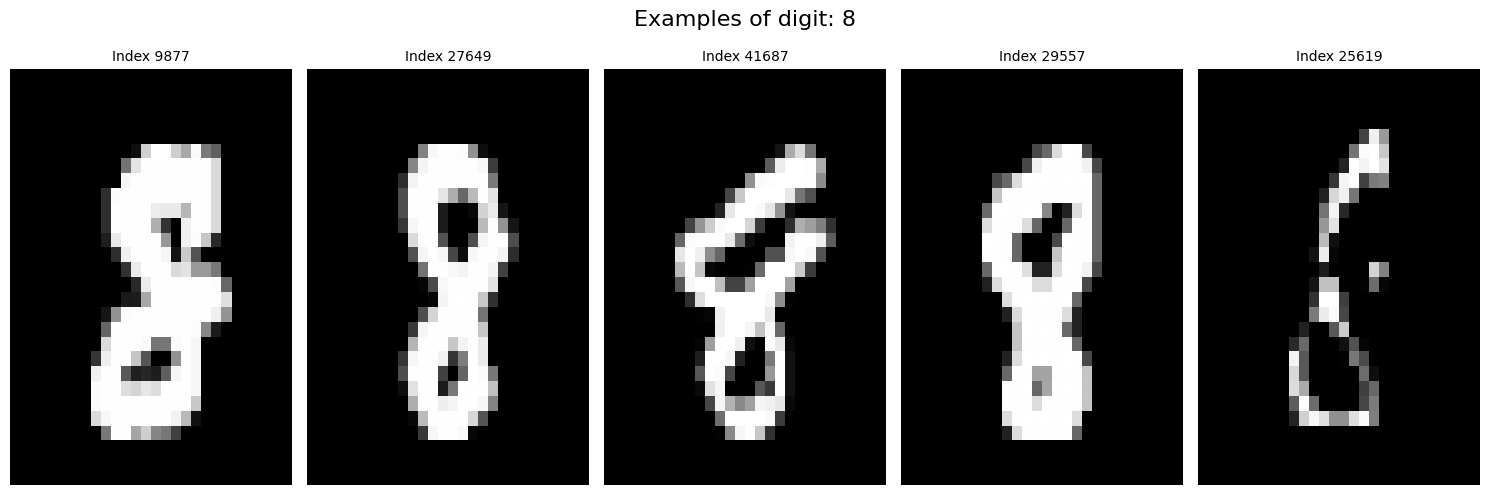

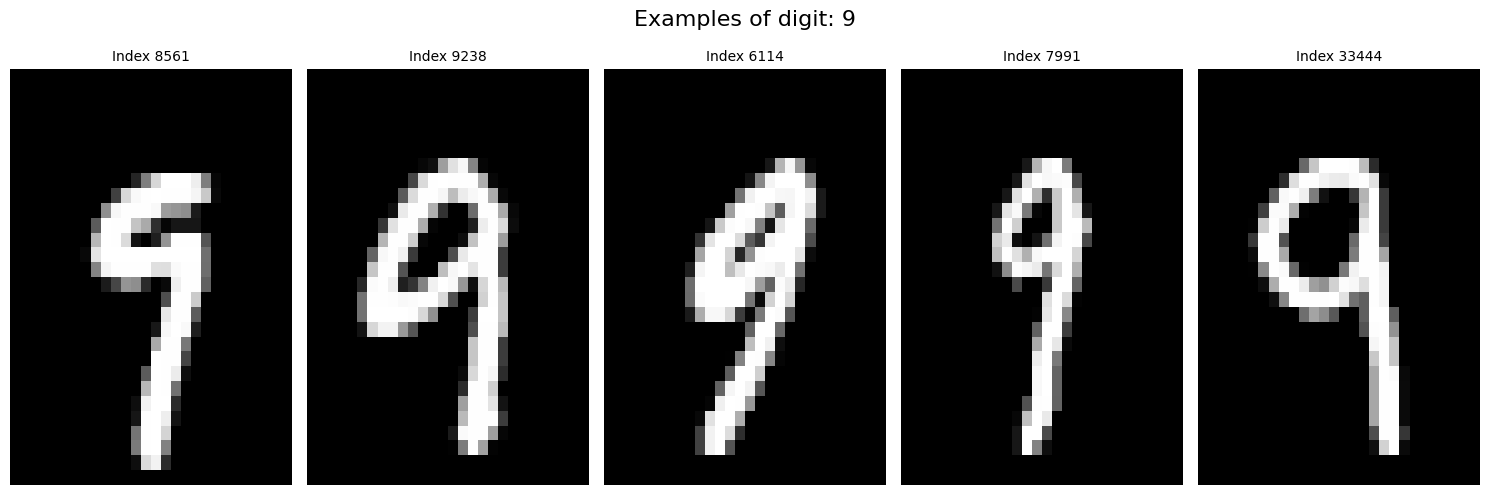

In [14]:
digit_classes = list(pd.Series(train_data['label'].unique()).sort_values())
number_digit_to_display = 5

for digit in digit_classes:
    
    fig, ax = plt.subplots(nrows=1, ncols=number_digit_to_display, figsize=(15,5))
    fig.suptitle(f'Examples of digit: {digit}', fontsize=16)
    
    digits_with_the_same_label = train_data[train_data['label'] == digit].iloc[:,1:]
    random_indexes_list = list(digits_with_the_same_label.sample(n=number_digit_to_display).index)

    for ax, index in zip(ax, random_indexes_list):
        image = train_data.iloc[index,1:].values.reshape(image_size, image_size)
        
        sns.heatmap(
            ax=ax,
            data=image,
            cbar=False,
            cmap='Greys_r',
            xticklabels=False,
            yticklabels=False
        )
        ax.set_title(f'Index {index}', fontsize=10)
    
    plt.tight_layout()
    plt.show()

<div style="background-color: #f9f9f9; border-left: 6px solid #696969; padding: 15px; font-family: 'Courier New', sans-serif; font-size: 16px; line-height: 1.6;">
  <strong>The images are readable, have good contrast and correct labels.</strong>
</div>

<div style="color:#4B4B4B; padding:5px; font-size:25px; font-weight:bold; font-family:'Courier New', monospace;">
  Preprocessing 🛠️
</div>

<div style="color:#cc6600; padding:5px; font-size:18px; font-weight:bold; font-family:'Courier New', monospace;">
  Train-Test Split
</div>

In [15]:
# Splitting the data into independent (features) and dependent (target) variables
X = train_data.drop(['label'], axis=1)
y = train_data['label']

# Splitting into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<div style="color:#cc6600; padding:5px; font-size:18px; font-weight:bold; font-family:'Courier New', monospace;">
  Feature Engineering
</div>

In [16]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<div style="color:#4B4B4B; padding:5px; font-size:25px; font-weight:bold; font-family:'Courier New', monospace;">
  Train Models 📈
</div>

<div style="background-color:#191970; color:white; padding:5px; font-size:18px; font-weight:bold; font-family:'Courier New', monospace;">
  Logistic Regression
</div>

In [17]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

y_pred_logreg = logreg.predict(X_test_scaled)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f'Test set Accuracy: {accuracy_logreg:.4f}')

Test set Accuracy: 0.9127


The accuracy of 91% shows that the model performs well on the test data.

In [18]:
# Check for overfitting and underfitting

train_pred_logreg = logreg.predict(X_train_scaled)
train_accuracy_logreg = accuracy_score(y_train, train_pred_logreg)
print(f'Training-set Accuracy: {train_accuracy_logreg:.4f}')

Training-set Accuracy: 0.9461


The accurasies (Test: 91%, Train: 95%) sugest that the model is slightly overfitting the training data.

In [19]:
# Confusion Matrix

def plot_confusion_matrix(y_true, y_pred, cmap='Blues', title='Confusion Matrix'):
    
    cm = confusion_matrix(y_true, y_pred)
    
    labels = list(pd.Series(y_true.unique()).sort_values())
    
    plt.figure(figsize=(12,8))
    sns.heatmap(cm, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

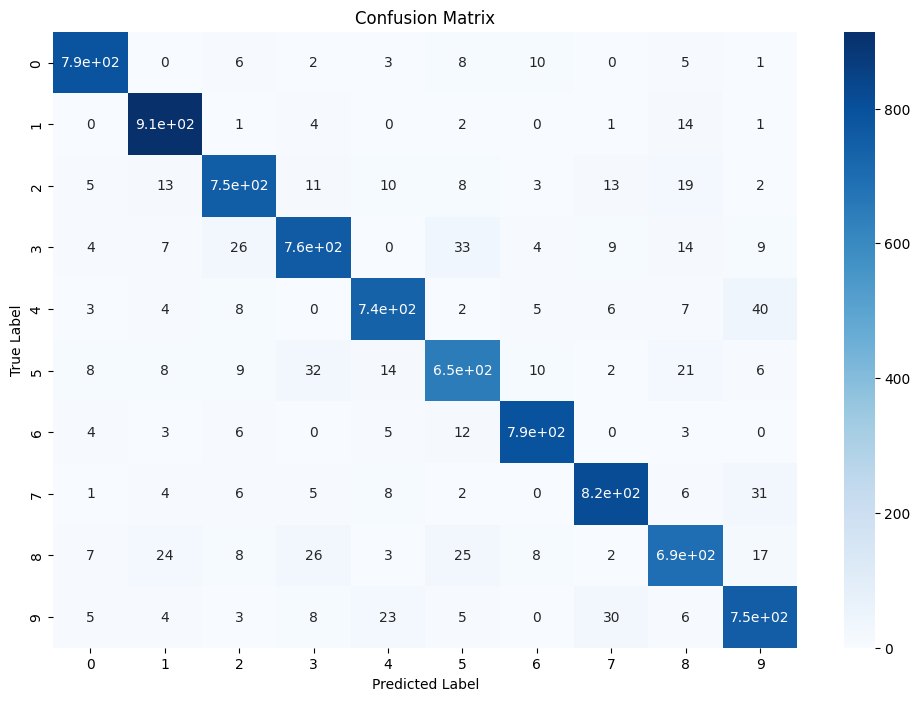

In [20]:
plot_confusion_matrix(y_test, y_pred_logreg, cmap='Blues', title='Confusion Matrix - Logistic Regression')

In [21]:
# Error-Label Count Correlation

cm_logreg = confusion_matrix(y_test, y_pred_logreg)

def error_label_count_correlation(confusion_matrix):

    df_cm = pd.DataFrame(confusion_matrix)
    label_counts = pd.Series(y_test).value_counts().sort_index().values
    
    errors_per_class = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    
    df = pd.DataFrame({
        'Class': df_cm.value_counts().index.names,
        'Errors': errors_per_class,
        'Label Counts': label_counts
    })
    
    correlation = df['Errors'].corr(df['Label Counts'])
    return correlation

In [22]:
print(f'Correlation between errors and label counts: {error_label_count_correlation(cm_logreg):.4f}')

Correlation between errors and label counts: -0.5227


<div style="background-color: #f9f9f9; border-left: 6px solid #696969; padding: 15px; font-family: 'Courier New', sans-serif; font-size: 16px; line-height: 1.6;">
  <strong>Error-Label Count Correlation Analysis</strong><br><br>
    A negative value of correlation (-0.52) betweem errors and label counts suggest that classes with fewer samples tend to have more errors. This meaning that imbalanced data might affect the model's performance.<br>
    To solve this problem Im going to apply class weight balancing to give more importance to minority classes during training.
</div>

In [23]:
# Logistic Regression with Class Weight Balancing

logreg_class_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg_class_balanced.fit(X_train_scaled, y_train)

y_pred_logreg_class_balanced = logreg_class_balanced.predict(X_test_scaled)

accuracy_logreg_class_balanced = accuracy_score(y_test, y_pred_logreg_class_balanced)
print(f'Test set Accuracy: {accuracy_logreg_class_balanced:.4f}')

train_pred_logreg_class_balanced = logreg_class_balanced.predict(X_train_scaled)
train_accuracy_logreg_class_balanced = accuracy_score(y_train, train_pred_logreg_class_balanced)
print(f'Training-set Accuracy: {train_accuracy_logreg_class_balanced:.4f}')

Test set Accuracy: 0.9126
Training-set Accuracy: 0.9465


<div style="background-color: #f9f9f9; border-left: 6px solid #696969; padding: 15px; font-family: 'Courier New', sans-serif; font-size: 16px; line-height: 1.6;">
    The accuracies after training logistic regression with balanced class weights didn't improve significantly. Maybe balancing class weights alone is not enough to address the class imbalance issue in this dataset.<br><br>
    In the next step I'm going to apply dimensionality reduction using PCA to see if this method helps reduce overfitting.
</div>

In [24]:
# Dimensionality Reduction - PCA

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [25]:
# Logistic Regression with PCA

logreg_pca = LogisticRegression(max_iter=1000)
logreg_pca.fit(X_train_pca, y_train)

y_pred_logreg_pca = logreg_pca.predict(X_test_pca)
accuracy_logreg_pca = accuracy_score(y_test, y_pred_logreg_pca)
print(f'Accuracy after PCA for Logistic Regression {accuracy_logreg_pca:.4f}')

train_pred_logreg_pca = logreg_pca.predict(X_train_pca)
train_accuracy_logreg_pca = accuracy_score(y_train, train_pred_logreg_pca)
print(f'Training-set Accuracy: {train_accuracy_logreg_pca:.4f}')

Accuracy after PCA for Logistic Regression 0.9136
Training-set Accuracy: 0.9249


<div style="background-color: #f9f9f9; border-left: 6px solid #696969; padding: 15px; font-family: 'Courier New', sans-serif; font-size: 16px; line-height: 1.6;">
    The model trained on PCA-reduced features with n_components=100 achieved an accuracy of 91.38% on the test set and 92.51% on the training set. This shows that <strong>dimensionality reduction helped reduce overfitting</strong>.<br><br>
    Now, I will verify if combining two methods - dimensionality reduction and balanced class weights - can improve predictions.
</div>

In [26]:
# Logistic Regression with PCA-reduced features and balanced class weights

logreg_pca_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg_pca_balanced.fit(X_train_pca, y_train)

y_pred_logreg_pca_balanced = logreg_pca_balanced.predict(X_test_pca)
accuracy_logreg_pca_balanced = accuracy_score(y_test, y_pred_logreg_pca_balanced)
print(f'Test set Accuracy: {accuracy_logreg_pca:.4f}')

train_pred_logreg_pca_balanced = logreg_pca.predict(X_train_pca)
train_accuracy_logreg_balanced = accuracy_score(y_train, train_pred_logreg_pca_balanced)
print(f'Training-set Accuracy: {train_accuracy_logreg_balanced:.4f}')

Test set Accuracy: 0.9136
Training-set Accuracy: 0.9249


<div style="background-color: #f9f9f9; border-left: 6px solid #696969; padding: 15px; font-family: 'Courier New', sans-serif; font-size: 16px; line-height: 1.6;">
    Combining PCA and balanced class weights to improve Logistic Regression predictions didn't lead to any change in accuracy. The test and training accuracies are the same as when using PCA alone.
</div>

<div style="background-color:#006400; color:white; padding:5px; font-size:18px; font-weight:bold; font-family:'Courier New', monospace;">
  Artificial Neural Network
</div>

In [27]:
# Create method to train a single ANN model

def train_ann(X_train, y_train,
              neurons=[128, 64],
              activation='relu',
              loss='sparse_categorical_crossentropy',
              use_batch_norm=False,
              epochs=5,
              batch_size=32,
              seed=42,
              verbose=0):

    num_pixels = X_train.shape[1]
    num_classes = len(np.unique(y_train))

    model = Sequential()
    
    # Inupt Layer
    model.add(tf.keras.Input(shape=(num_pixels, ))) # (784, ) -> tuple with one element 784
    
    for n in neurons:
        model.add(Dense(n, activation=activation))
        if use_batch_norm:
            model.add(BatchNormalization())
            
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=['accuracy']
    )
    
    model.fit(X_train, 
              y_train, 
              epochs=epochs,
              batch_size=batch_size,
              validation_split=0.1,
              verbose=verbose)

    return model

In [28]:
# Create method to return accuracy, F1-score and confusion matrix for a trained model on test data and accuracy on training data

def evaluate_ann_model(model, X_train, y_train, X_test, y_test):

    def error_label_count_correlation(cm):
        
        # List with number of error per class : sum of each row minus diagonal element (true predictions):
        errors_per_class = cm.sum(axis=1) - np.diag(cm)

        # List with number of occurrences for each class (true + false predictions):
        true_counts = cm.sum(axis=1)

        # Porównanie zależności liczb z dwóch list. Macierz Pearsona:
        corr_matrix = np.corrcoef(errors_per_class, true_counts)
        
        return corr_matrix[0,1]
        # Return correlation coefficient in range [-1, 1]:
        # 1 means perfect positive correlation,
        # -1 means perfect negative correlation,
        # 0 means no linear correlation
        
    y_pred_all = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_all, axis=1)

    train_pred_all = model.predict(X_train, verbose=0)
    train_pred = np.argmax(train_pred_all, axis=1)
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    train_acc = accuracy_score(y_train, train_pred)
    correlation = error_label_count_correlation(cm)
    
    return acc, f1, cm, train_acc, correlation

In [29]:
# Unified method to train and evaluate an ANN model - training + metrics + confusion matrix

def train_and_evaluate_ann_full(X_train, y_train, X_test, y_test, **kwargs):
    
    model = train_ann(X_train, y_train, **kwargs)
    
    acc, f1, cm, train_acc, correlation = evaluate_ann_model(
        model, X_train, y_train, X_test, y_test)

    df = pd.DataFrame({
        'Metric': ['F1-score', 'Test Accuracy', 'Training Accuracy', 'Correlation Errors-Label Counts'],
        'Value': [f1, acc, train_acc, correlation]
    })
    
    return model, f1, df, cm

In [30]:
def grid_search_ann(X_train, y_train, X_test, y_test, param_grid):
    
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    combinations = list(product(*values)) # tworzy wszystkie kombinacje z listy values

    best_f1 = 0
    best_model = None
    best_params = None
    best_df = None
    best_cm = None
    
    for combo in combinations:
        params = dict(zip(keys, combo)) # tworzy słownik z dwóch list
        model, f1, df, cm = train_and_evaluate_ann_full(X_train, y_train, X_test, y_test, **params)

        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = params
            best_df = df
            best_cm = cm
        
    return best_model, best_params, best_df, best_cm

2025-07-18 12:54:17.529774: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Best parameters found: {'neurons': [128, 64], 'activation': 'tanh', 'batch_size': 32, 'epochs': 5, 'use_batch_norm': True, 'verbose': 0}


,Metric,Value
0,F1-score,0.970101
1,Test Accuracy,0.970119
2,Training Accuracy,0.988125
3,Correlation Errors-Label Counts,-0.070258


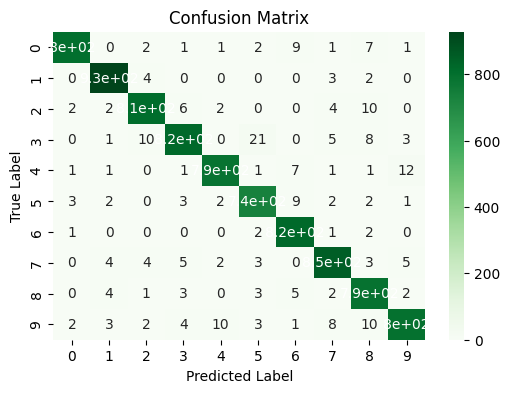

In [31]:
param_grid = {
    'neurons': [[128, 64], [256, 128]],
    'activation': ['relu', 'tanh'],
    'batch_size': [32],
    'epochs': [5],
    'use_batch_norm': [True, False],
    'verbose': [0]
}

best_model, best_params, best_df, best_cm = grid_search_ann(X_train_scaled, y_train, X_test_scaled, y_test, param_grid=param_grid)

print("Best parameters found:", best_params)
display(best_df.style.background_gradient(cmap='Greens').set_caption("Best Model Metrics"))

plt.figure(figsize=(6,4))
sns.heatmap(best_cm, annot=True, cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<div style="color:#006400; padding:5px; font-size:18px; font-weight:bold; font-family:'Courier New', monospace;">
  Implement Dimensionality Reduction - PCA
</div>

In [32]:
# Dimensionality Reduction - PCA

pca = PCA(n_components=100)

X_train_pca = pca.fit_transform(X_train_scaled) # 100 features
X_test_pca = pca.transform(X_test_scaled)

Best parameters found: {'neurons': [256, 128], 'activation': 'relu', 'batch_size': 32, 'epochs': 5, 'use_batch_norm': True, 'verbose': 0}


,Metric,Value
0,F1-score,0.973212
1,Test Accuracy,0.973214
2,Training Accuracy,0.993185
3,Correlation Errors-Label Counts,-0.284760


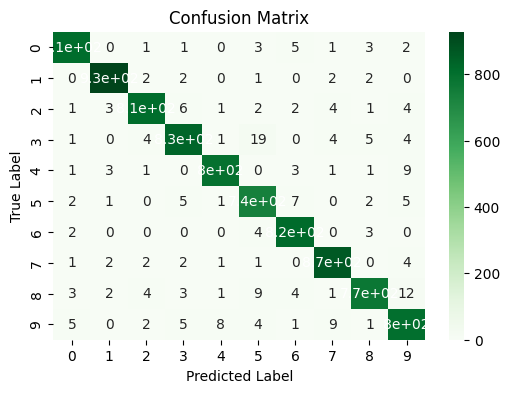

In [33]:
param_grid = {
    'neurons': [[128, 64], [256, 128]],
    'activation': ['relu', 'tanh'],
    'batch_size': [32],
    'epochs': [5],
    'use_batch_norm': [True, False],
    'verbose': [0]
}

best_model_pca, best_params_pca, best_df_pca, best_cm_pca = grid_search_ann(X_train_pca, y_train, X_test_pca, y_test, 
                                                                            param_grid=param_grid)

print("Best parameters found:", best_params_pca)
display(best_df_pca.style.background_gradient(cmap='Greens').set_caption("Best Model Metrics"))

plt.figure(figsize=(6,4))
sns.heatmap(best_cm_pca, annot=True, cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<div style="background-color:#cc6600; color:white; padding:5px; font-size:18px; font-weight:bold; font-family:'Courier New', monospace;">
  Observations and Conclusions
</div>

<div style="background-color: #f9f9f9; border-left: 6px solid #696969; padding: 15px; font-family: 'Courier New', sans-serif; font-size: 16px; line-height: 1.6;">
    - Logistic Regression with PCA achives good accuracy (91%), showing that dimensionality reduction helps simplify the model while keeping decent performance.<br>
    - ANN without PCA perform better than Logistic Regression, with test accuracy 96.7% and high F1-score with similar value. This indicates that neural network captures more complex patterns.<br>
    - The negative correlation between errors and label counts in both ANN models indicates that classes with more samples tend to have fewer errors, which is expected.<br>
    - Overall, applying PCA before ANN training is beneficial here: it reduces dimensionality, speeds up training, and slightly improves accuracy.
</div>

In [34]:
# Competition

In [35]:
test_X_test_scaled = scaler.fit_transform(test_data)
test_X_test_pca = pca.transform(test_X_test_scaled)
test_y_pred_all = best_model_pca.predict(test_X_test_pca)
test_y_pred = test_y_pred_all.argmax(axis=1)

submission = pd.DataFrame({'ImageId': range(1, len(test_y_pred)+1), 'Label': test_y_pred})
submission.to_csv('submission.csv', index=False)
submission.head()

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
